In [1]:
import os, gc
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
df = pd.read_csv("styles.csv", on_bad_lines="skip")
df = df.dropna(subset=["id", "masterCategory"]).reset_index(drop=True)
print("Total rows:", df.shape)
# Keep only first 2000 samples (to save RAM in Colab)
df = df.sample(n=2000, random_state=42).reset_index(drop=True)

Total rows: (44424, 10)


In [4]:
# Image folder
img_dir = "images"

# Load & resize
images, labels, ids = [], [], []
for i, row in df.iterrows():
    img_path = os.path.join(img_dir, str(row["id"])+".jpg")
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert("RGB").resize((224,224))
            images.append(np.array(img))
            labels.append(row["masterCategory"])
            ids.append(row["id"])
        except:
            pass

images = np.array(images)
labels = np.array(labels)
ids = np.array(ids)

print("Loaded images:", images.shape)

Loaded images: (2000, 224, 224, 3)


In [5]:
# ======================================
# STEP 4: Feature Extraction (ResNet50 in batches)
# ======================================
resnet = ResNet50(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3))

batch_size = 64
features_list = []

for i in range(0, len(images), batch_size):
    batch = images[i:i+batch_size]
    batch_pre = preprocess_input(batch)
    feats = resnet.predict(batch_pre, verbose=0)
    features_list.append(feats)
    del batch, batch_pre, feats
    gc.collect()

features = np.vstack(features_list)
print("Final feature shape:", features.shape)

Final feature shape: (2000, 2048)


In [6]:
# ======================================
# STEP 5: Train KNN
# ======================================
#knn = NearestNeighbors(n_neighbors=6, metric="cosine")
#knn.fit(features)


from sklearn.neighbors import KNeighborsClassifier

# Use distance-weighted voting, cosine similarity, k=6
knn = KNeighborsClassifier(n_neighbors=15, metric="cosine", weights="distance")

# Train on features + labels
knn.fit(features, labels)

,n_neighbors,15
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'cosine'
,metric_params,None
,n_jobs,None


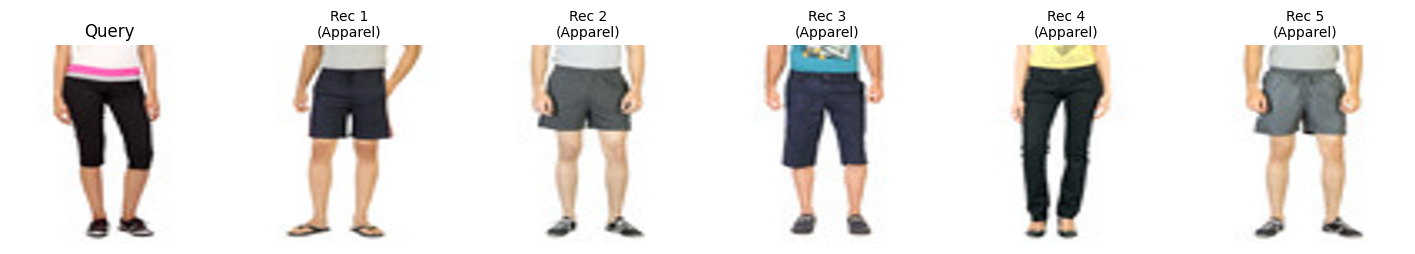

In [7]:

def recommend(img_index, top_k=5):
    """
    Displays the query image + top_k recommended images with category labels.
    """
    distances, indices = knn.kneighbors([features[img_index]], n_neighbors=top_k+1)  # +1 for query itself
    indices = indices[0]  # flatten

    plt.figure(figsize=(3*len(indices), 4))  # width scales with number of images

    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)  # dynamic subplot
        plt.imshow(images[idx])
        plt.axis("off")
        if i == 0:
            plt.title("Query")
        else:
            plt.title(f"Rec {i}\n({labels[idx]})", fontsize=10)

    plt.show()

recommend(10, top_k=5)  # shows query + 5 recommendations


In [8]:

# ======================================
# STEP 7: Accuracy & Confusion Matrix
# ======================================
# Encode labels
le = LabelEncoder()
y_true = le.fit_transform(labels)

# Predict nearest neighbor category
y_pred = []
for i in range(len(features)):
    distances, indices = knn.kneighbors([features[i]])
    neighbor_labels = labels[indices[0][1:]]  # exclude itself
    if len(neighbor_labels) > 0:
        y_pred.append(neighbor_labels[0])
    else:
        y_pred.append(labels[i])

y_pred_enc = le.transform(y_pred)

print("Classification Report:\n", classification_report(y_true, y_pred_enc))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_enc))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       524
           1       0.99      0.99      0.99       967
           2       0.98      1.00      0.99       401
           3       0.18      0.25      0.21         8
           4       0.97      0.92      0.94        97
           5       1.00      0.67      0.80         3

    accuracy                           0.98      2000
   macro avg       0.85      0.80      0.82      2000
weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
 [[503   6   6   6   3   0]
 [  6 957   1   3   0   0]
 [  0   0 401   0   0   0]
 [  5   1   0   2   0   0]
 [  6   2   0   0  89   0]
 [  1   0   0   0   0   2]]


In [9]:
import pickle

# ======================================
# STEP 8: Save for Streamlit
# ======================================
np.save("images.npy", images)
np.save("features.npy", features)
np.save("labels.npy", labels)

with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)

print("✅ All files saved for Streamlit (images.npy, features.npy, labels.npy, knn_model.pkl)")

✅ All files saved for Streamlit (images.npy, features.npy, labels.npy, knn_model.pkl)


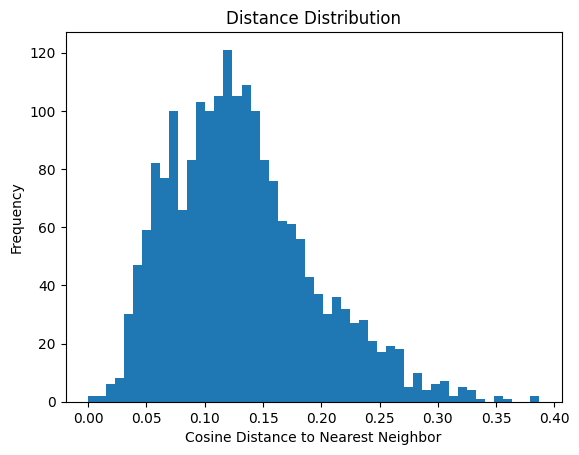

In [10]:
distances, _ = knn.kneighbors(features)
plt.hist(distances[:,1], bins=50)  # skip self-distance at index 0
plt.xlabel("Cosine Distance to Nearest Neighbor")
plt.ylabel("Frequency")
plt.title("Distance Distribution")
plt.show()

c:\Users\Asif\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asif\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asif\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Classification Report:
                 precision    recall  f1-score   support

   Accessories       0.95      0.96      0.96       524
       Apparel       0.98      0.99      0.99       967
      Footwear       0.99      1.00      0.99       401
    Free Items       0.00      0.00      0.00         8
 Personal Care       1.00      0.89      0.94        97
Sporting Goods       0.00      0.00      0.00         3

      accuracy                           0.97      2000
     macro avg       0.65      0.64      0.65      2000
  weighted avg       0.97      0.97      0.97      2000

Confusion Matrix:
 [[503  17   4   0   0   0]
 [  7 959   1   0   0   0]
 [  0   0 401   0   0   0]
 [  7   1   0   0   0   0]
 [ 10   1   0   0  86   0]
 [  2   0   1   0   0   0]]


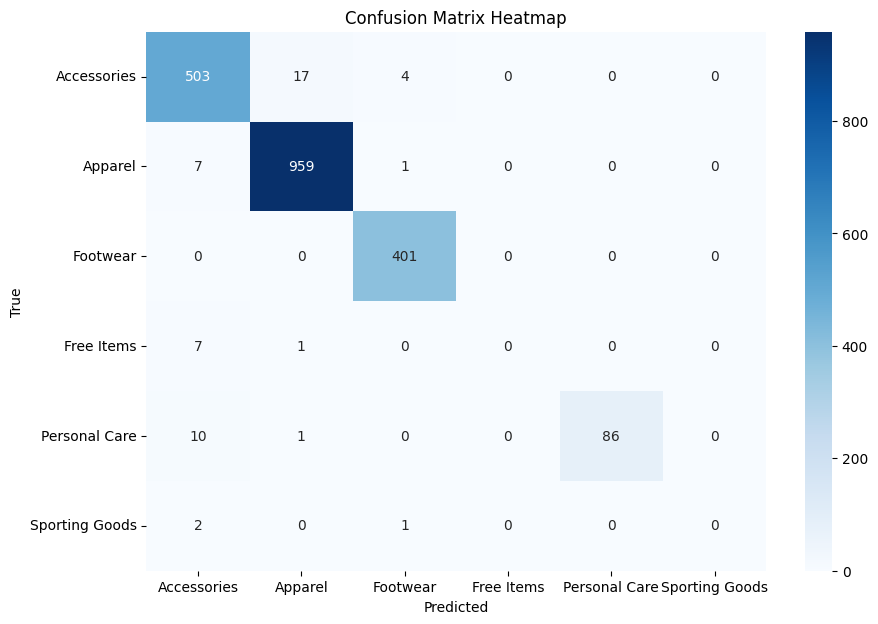

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ======================================
# Evaluation Function
# ======================================
def evaluate_recommendations(features, labels, k=5):
    le = LabelEncoder()
    labels_enc = le.fit_transform(labels)   # convert string → int

    y_true, y_pred = [], []
    for i in range(len(features)):
        query_label = labels_enc[i]
        distances, indices = knn.kneighbors([features[i]], n_neighbors=k+1)
        rec_indices = indices[0][1:]  # skip itself

        # Predicted label = majority class among recommendations
        rec_labels = labels_enc[rec_indices]
        pred_label = np.bincount(rec_labels).argmax()

        y_true.append(query_label)
        y_pred.append(pred_label)

    return y_true, y_pred, le

y_true, y_pred, le = evaluate_recommendations(features, labels, k=5)

print("Classification Report:\n",
      classification_report(y_true, y_pred, target_names=le.classes_))

print("Confusion Matrix:\n",
      confusion_matrix(y_true, y_pred))

# Confusion Matri
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()